In [1]:
from binder_diblock_vertex_competitive import *
from itertools import permutations as perms
from itertools import product
import numpy as np

# s2, s3, s4 calc

In [3]:
def calc_sf2_chromo_shlk(chrom, M2s, k_vec = np.logspace(-3, -1, 30)):
    # calculates sf2 using rank 1 monomer correlation tensor 
    [n_bind, v_int, Vol_int, e_m, rho_c, rho_s, poly_marks, M, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

    M2_AA, M2_AB, M2_BA, M2_BB, M1_cgam0, M1_cgam1, M2_cc = M2s

    M = np.shape(M2_AA)[0]
    nk = len(k_vec)
    N = M*N_m
    
    S2_AA_arr = np.zeros(nk)
    S2_AB_arr = np.zeros(nk)
    S2_BA_arr = np.zeros(nk)
    S2_BB_arr = np.zeros(nk)
    
    S2_cgam0_arr = np.zeros(nk)
    S2_cgam1_arr = np.zeros(nk)
    S2_cc_arr = np.zeros(nk)


    for i, k in enumerate(k_vec):
        C = np.zeros(M)
        k = np.linalg.norm(k)
        x_m = (1/6) * N_m * b**2 * k**2

        #j1 = j2, s1 > s2
        index = 0#(j1 == j2)
        constant = 1
        debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1) 

    #     C[np.where((index) != 0)] += debye
        C[0] += debye

        #j1 > j2, s1 s2 any
        index = np.arange(0, M, 1)#(j1 > j2) #index = del!
        constant = np.exp(-x_m*index)
        integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms

        C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral

        S2_AA_arr[i] = np.sum((1/M**2) * C * M2_AA)
        S2_AB_arr[i] = np.sum((1/M**2) * C * M2_AB)
        S2_BA_arr[i] = np.sum((1/M**2) * C * M2_BA)
        S2_BB_arr[i] = np.sum((1/M**2) * C * M2_BB)
        
        S2_cgam0_arr[i] = np.sum((1/M**2) * C * M1_cgam0)
        S2_cgam1_arr[i] = np.sum((1/M**2) * C * M1_cgam1)
        S2_cc_arr[i] = np.sum((1/M**2) * C * M2_cc)
        
    return S2_AA_arr*N**2, S2_AB_arr*N**2, S2_BA_arr*N**2, S2_BB_arr*N**2, S2_cgam0_arr*N**2, S2_cgam1_arr*N**2, S2_cc_arr*N**2

def eval_and_reduce_cc(len_marks_1):
    res = np.zeros(len_marks_1)
    res[0] = len_marks_1
    res[1:] = np.arange(2, 2*(len_marks_1), 2)[::-1]
    return res

def eval_and_reduce_cgam(s_bnd_vec):
#     [marks_1, marks_2] = poly_marks
    
    # s_bnd = s_bnd.astype(DATA_TYPE)
    M = len(s_bnd_vec)
    
    sisj_tens = np.zeros(M, dtype = DATA_TYPE)

    # s_bnd_vec = s_bnd[pairs_ind] 
    
#         sisj_tens[0] = np.sum(s_bnd_vec)
#         for i in range(M-1):
#             sisj_tens[-(i+1)] = np.sum(s_bnd_vec[:(i+1)]) + np.sum(s_bnd_vec[-(i+1):])
    
    forward_cumsum = np.cumsum(s_bnd_vec)
    backward_cumsum = np.cumsum(s_bnd_vec[::-1])#[::-1]

    sisj_tens[0] = forward_cumsum[-1]
    sisj_tens[1:] = (forward_cumsum[:-1] + backward_cumsum[:-1])[::-1]
            
          
    return sisj_tens
        
        
def eval_and_reduce_sisj_bind_simp(chrom, s_bnd_A, s_bnd_B):
    [n_bind, v_int, Vol_int, e_m, rho_c, rho_s, poly_marks, M, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

#     [marks_1, marks_2] = poly_marks

    # s_bnd_A = s_bnd#[pairs_ind+9*gam1_ind]
    # s_bnd_B = s_bnd#[pairs_ind+9*gam2_ind]
    
    # M = len(s_bnd_A)
    sisj_tens = np.zeros(M, dtype = DATA_TYPE)
    
#     ind = np.arange(0,M,1)

#     for i in range(M):
#         if i == 0:
#             sisj_tens[i] = np.sum(s_bnd_A * s_bnd_B)
#         else:
#             sisj_tens[-i] = np.sum(s_bnd_A[:i]*s_bnd_B[-i:]) + np.sum(s_bnd_A[-i:]*s_bnd_B[:i])

#     ind = np.arange(0,M,1)
    
#     sisj_tens[0] = np.sum(s_bnd_A * s_bnd_B)
#     for i in range(M-1):
#         sisj_tens[-(i+1)] = np.sum(s_bnd_A[:(i+1)]*s_bnd_B[-(i+1):]) + np.sum(s_bnd_A[-(i+1):]*s_bnd_B[:(i+1)])

    sisj_tens[0] = np.sum(s_bnd_A * s_bnd_B)
#     conv = np.convolve(s_bnd_A, s_bnd_B[::-1])
    conv = signal.convolve(s_bnd_A, s_bnd_B[::-1])
    sisj_tens[1:] = conv[:M-1][::-1] + conv[:M-1:-1][::-1]
    
    return sisj_tens

In [4]:
def calc_single_monomer_matrix_3(s_bind_A, s_bind_B, alphas):
    # calculates the alph1 aph2 alph3 monomer identity cross correlation matrix
    # assumes all polymers consist of monomers with the same length N_m

    # alphas is the seqence that identifies the correlation. 0 indicates polymer, 1, indicates protein 1 ,etc

    a1, a2, a3 = alphas
    poly = np.ones(len(s_bind_A))
    sig_arr = [poly, s_bind_A, s_bind_B]
    return np.einsum('i,j,k',sig_arr[a1],sig_arr[a2],sig_arr[a3])

def calc_single_monomer_matrix_4(s_bind_A, s_bind_B, alphas):
    # calculates the alph1 aph2 alph3 monomer identity cross correlation matrix
    # assumes all polymers consist of monomers with the same length N_m

    # alphas is the seqence that identifies the correlation. 0 indicates polymer, 1, indicates protein 1 ,etc

    a1, a2, a3, a4 = alphas
    poly = np.ones(len(s_bind_A))
    sig_arr = [poly, s_bind_A, s_bind_B]
    return np.einsum('i,j,k,l',sig_arr[a1],sig_arr[a2],sig_arr[a3], sig_arr[a4])

def calc_mon_mat_3(s_bind_A, s_bind_B):
    nm = len(s_bind_A)
    sig_inds = [0,1,2] # polymer, gama1, gamma2
    M3_arr = np.zeros((len(sig_inds), len(sig_inds), len(sig_inds)), dtype= "object")
    for a1, a2, a3 in product(sig_inds, repeat=3):
        # print([a1, a2, a3])
        M3_arr[a1][a2][a3] = calc_single_monomer_matrix_3(s_bind_A, s_bind_B, [a1, a2, a3])
    return M3_arr

def calc_mon_mat_4(s_bind_A, s_bind_B):
    nm = len(s_bind_A)
    sig_inds = [0,1,2] # polymer, gama1, gamma2
    M4_arr = np.zeros((len(sig_inds), len(sig_inds), len(sig_inds), len(sig_inds)), dtype= "object")
    for a1, a2, a3, a4 in product(sig_inds, repeat=4):
        M4_arr[a1][a2][a3][a4] = calc_single_monomer_matrix_4(s_bind_A, s_bind_B, [a1, a2, a3, a4])
    return M4_arr



In [5]:
# ADAPTED FROM gaus_vertex_pd_mix.py
def calc_sf3(chrom, M3_arr, k_vec, k_vec_2, plotting = False):
    # for a gaussian chain of M monomers, each of length N_m
    # N = mix.N
    # M = mix.M_ave
    # M_max = mix.M_max
    # N_m = mix.N_m
    # b = mix.b
    # M3_AAA, M3_AAB, M3_ABA, M3_BAA, M3_ABB, M3_BAB,  M3_BBA, M3_BBB = mix.M3s
    # nk = len(k_vec)
    
    [n_bind, v_int, Vol_int, e_m, rho_c, rho_s, poly_marks, M, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

    # M = np.shape(M2_AA)[0]
    nk = len(k_vec)
    N = M*N_m

    sig_inds = [0,1,2] #polymer, prot1, prot2
    S3_arr = np.zeros((len(sig_inds),len(sig_inds),len(sig_inds))) #polymer, prot1, prot2

    grid = np.indices((M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    
    # grid = np.indices((M_max,M_max,M_max))
    # j1 = grid[0]
    # j2 = grid[1]
    # j3 = grid[2]

    # S3_AAA_arr =  np.zeros(nk)
    # S3_BAA_arr = np.zeros(nk)
    # S3_BBA_arr = np.zeros(nk)
    # S3_BBB_arr = np.zeros(nk)
    
    # S3_ABA_arr = np.zeros(nk)
    # S3_BAB_arr = np.zeros(nk)
    
    # S3_AAB_arr = np.zeros(nk)
    # S3_ABB_arr = np.zeros(nk) 
    
    for i, k_1 in enumerate(k_vec):
        k_2 = k_vec_2[i]
        k_12 = k_1 + k_2

        # CASE 1; kA = k1 + k2, kB = k_1; S3 > S2 > S1 and S1 > S2 > S3
        case1 = [[k_12, k_1], [j3, j2, j1]]
        case1_deg = [[k_1, k_12], [j1, j2, j3]]

        # CASE 2; kA = k2, kB = k1 + k2; S2 > S1 > S3 and S3 > S1 > S2
        case2 = [[k_2, k_12], [j2, j1, j3]]
        case2_deg = [[k_12, k_2], [j3, j1, j2]]
        
        # CASE 3; kA = k2, kB = -k1; S2 > S3 > S1 and S1 > S3 > S2
        case3 = [[-k_2, k_1], [j2, j3, j1]] # SWITCHED negatives from -k_1
        case3_deg = [[k_1, -k_2], [j1, j3, j2]] # SWITCHED negatives from -k_1
        
        case_arr = [case1, case2, case3, case1_deg, case2_deg, case3_deg]
        # need to consider degenerate cases. flipping each element in array, then appending to original case array
        # case_arr = np.vstack((case_arr, [[np.flipud(el) for el in cse] for cse in case_arr]))
        
#        for each case and sub case, add to a matrix C(j1, j2, j3) which contains the contribution to the overall S3
#        then sum over all indices. Need to keep track of js so that aproiate multiplications with cross corr matrix M3        
        C = np.zeros((M,M,M))

        for cse in case_arr:
            kA, kB = cse[0]
            ordered_js = cse[1]
            
            xm_A = (1/6) * N_m * b**2 * np.linalg.norm(kA)**2
            xm_B = (1/6) * N_m * b**2 * np.linalg.norm(kB)**2
            
            C = calc_case_s3(C, xm_A, xm_B, ordered_js)
        for a1, a2, a3 in product(sig_inds, repeat=3):
            # print([a1, a2, a3])
            # M3_arr[a1][a2][a3] = calc_single_monomer_matrix_3(s_bind_A, s_bind_B, [a1, a2, a3])
            S3_arr[a1][a2][a3] += np.sum((1/M**3) * M3_arr[a1][a2][a3] * C)*(N**3)
        
        # S3_AAA_arr[i] += np.sum((1/M**3) * M3_AAA * C)*(N**3)
        # S3_BAA_arr[i] += np.sum((1/M**3) * M3_BAA * C)*(N**3)
        # S3_BBA_arr[i] += np.sum((1/M**3) * M3_BBA * C)*(N**3)
        # S3_BBB_arr[i] += np.sum((1/M**3) * M3_BBB * C)*(N**3)
        
        # S3_ABA_arr[i] += np.sum((1/M**3) * M3_ABA * C)*(N**3)
        # S3_BAB_arr[i] += np.sum((1/M**3) * M3_BAB * C)*(N**3)
        
        # S3_AAB_arr[i] += np.sum((1/M**3) * M3_AAB * C)*(N**3)
        # S3_ABB_arr[i] += np.sum((1/M**3) * M3_ABB * C)*(N**3)
        
    # s3 = np.zeros((2,2,2)) 
    # s3[0][0][0] = S3_AAA_arr[0]
    # s3[1][0][0] = S3_BAA_arr[0]
    # s3[0][1][0] = S3_ABA_arr[0]
    # s3[0][0][1] = S3_AAB_arr[0]
    # s3[0][1][1] = S3_ABB_arr[0]
    # s3[1][0][1] = S3_BAB_arr[0]
    # s3[1][1][0] = S3_BBA_arr[0]
    # s3[1][1][1] = S3_BBB_arr[0]
    
    # if plotting: # matrix only contains single value, for calculating gamma functions
    #     return S3_AAA_arr, S3_AAB_arr, S3_ABA_arr, S3_BAA_arr, S3_ABB_arr, S3_BAB_arr,  S3_BBA_arr, S3_BBB_arr
    
    return S3_arr

def calc_case_s3(C, xm_A, xm_B, ordered_js):

    jmax, jmid, jmin = ordered_js
    
    cylindrical = False
    epsilon = 0.0000001
    if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
        cylindrical = True
    
    xm_A_eq_0 = False
    if xm_A < 1e-5:
        xm_A_eq_0 = True
        
    xm_B_eq_0 = False
    if xm_B < 1e-5:
        xm_B_eq_0 = True

    #for each sub case, looking at the degenerate case where 1 and 2 are switched
    constant = np.exp(-xm_A*(jmax - jmid)) * np.exp(-xm_B*(jmid - jmin)) 

    # sub case 1; jmax > jmid > jmin, {s1, s2, s3} any 
    index = (jmax > jmid) * (jmid > jmin)
    
    if cylindrical == True:
        integral = (1 / xm_A**2) * 2 * (-1 + np.cosh(xm_A))
    elif xm_B_eq_0:
        integral = (2*(-1+np.cosh(xm_A)))/ (xm_A**2)
    elif xm_A_eq_0:
        integral = (2*(-1+np.cosh(xm_B)))/ (xm_B**2)
    else:
        integral = (-2 / (xm_A * (xm_A - xm_B) * xm_B)) \
        * (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))

    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
    
    # sub case 2; jmax = jmid > jmin, s3 > s2, {s1} any
    index = (jmax == jmid) * (jmid > jmin)
    
    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    elif xm_B_eq_0:
        integral = (-1 + xm_A + np.cosh(xm_A) - np.sinh(xm_A))/ (xm_A**2)
    elif xm_A_eq_0:
        integral = (np.exp(-xm_B)*(-1 + np.exp(xm_B))*(1+np.exp(xm_B)*(-1 + xm_B))) / (xm_B**3)   
    else:
        integral = ((-1 + np.exp(xm_B))/(xm_A * (xm_A - xm_B)*xm_B**2)) \
        * (xm_A + (-1 + np.exp(-xm_A))*xm_B - xm_A*np.cosh(xm_B) + xm_A*np.sinh(xm_B))

    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral 

    # BONUS sub case 4; jmax > jmid = jmin, s2 > s1, {s3} any 
    index = (jmax > jmid) * (jmid == jmin)
    
    if cylindrical == True:
        integral = (1 / xm_A**3) *( (2 + xm_A) * (-1 + np.cosh(xm_A)) - (xm_A * np.sinh(xm_A)) )
    elif xm_B_eq_0:
        integral = ((-2+xm_A)*(-1+np.cosh(xm_A))+ (xm_A*np.sinh(xm_A)))/ (xm_A**3)
    elif xm_A_eq_0:
        integral = (-1+xm_B+np.cosh(xm_B) - np.sinh(xm_B))/ (xm_B**2)
    else:
        integral = (((-1 + np.exp(xm_A))*(np.exp(-xm_A - xm_B)))/(xm_B * (xm_A - xm_B)*xm_A**2)) \
        * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B) * (xm_A -xm_B) + np.exp(xm_B)*xm_B)

    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral 

    # sub case 3; jmax = jmid = jmin, s3 > s2 > s1
    index = (jmax == jmid) * (jmid == jmin)

    if cylindrical == True:
        integral = (1 / xm_A**3) * (np.exp(-xm_A) * (2 + np.exp(xm_A)*(-2 + xm_A) + xm_A))
    elif xm_B_eq_0:
        integral = (2-2*np.exp(-xm_A) - 2*xm_A + xm_A**2)/ (2*xm_A**3)
    elif xm_A_eq_0:
        integral = (2-2*np.exp(-xm_B) - 2*xm_B + xm_B**2)/ (2*xm_B**3)
    else:
        integral = (1 / (xm_A**2 * xm_B - xm_A * xm_B**2))\
        * ( xm_A + (((-1 + np.exp(-xm_B)) * xm_A)/(xm_B)) - xm_B + ((xm_B - np.exp(-xm_A)*xm_B)/(xm_A)) )

    C[np.where(index != 0)] += 1\
                                    * constant[np.where(index != 0)]\
                                    * integral
    return C

In [6]:
def calc_sf4(chrom, M4_arr, k_vec, k_vec_2, k_vec_3, plotting = False):
    [n_bind, v_int, Vol_int, e_m, rho_c, rho_s, poly_marks, M, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

    nk = len(k_vec)
    N = M*N_m
    sig_inds = [0,1,2] #polymer, prot1, prot2
    S4_arr = np.zeros((len(sig_inds),len(sig_inds),len(sig_inds),len(sig_inds))) 

    grid = np.indices((M,M,M,M))
    j1 = grid[0]
    j2 = grid[1]
    j3 = grid[2]
    j4 = grid[3]
    
    for i, k1 in enumerate(k_vec):
        k2 = k_vec_2[i]
        k3 = k_vec_3[i]
        k12 = k1 + k2
        k13 = k1 + k3
        k23 = k2 + k3
        k123 = k1 + k2 + k3
        
        # CASE 1; kA = k1 + k2 + k3; kB = k_1 + k_2; kC = k_1  S4 > S3 > S2 > S1 (and reverse). All cases on wlcstat
        case1 = [[k123, k12, k1], [j4, j3, j2, j1]]
        case2 = [[k123, k12, k2], [j4, j3, j1, j2]]
        case3 = [[k123, k13, k1], [j4, j2, j3, j1]]
        case4 = [[k123, k23, k2], [j4, j1, j3, j2]]
        case5 = [[k123, k13, k3], [j4, j2, j1, j3]]
        case6 = [[k123, k23, k3], [j4, j1, j2, j3]]
        case7 = [[-k3, k12, k1], [j3, j4, j2, j1]]
        case8 = [[-k3, k12, k2], [j3, j4, j1, j2]]
        case9 = [[-k2, k13, k1], [j2, j4, j3, j1]]
        case10 = [[-k1, k23, k2], [j1, j4, j3, j2]]
        case11 = [[-k2, k13, k3], [j2, j4, j1, j3]]
        case12 = [[-k1, k23, k3], [j1, j4, j2, j3]]
        
        case1_deg = [[k1, k12, k123], [j1, j2, j3, j4]]
        case2_deg = [[k2, k12, k123], [j2, j1, j3, j4]]
        case3_deg = [[k1, k13, k123], [j1, j3, j2, j4]]
        case4_deg = [[k2, k23, k123], [j2, j3, j1, j4]]
        case5_deg = [[k3, k13, k123], [j3, j1, j2, j4]]
        case6_deg = [[k3, k23, k123], [j3, j2, j1, j4]]
        case7_deg = [[k1, k12, -k3], [j1, j2, j4, j3]]
        case8_deg = [[k2, k12, -k3], [j2, j1, j4, j3]]
        case9_deg = [[k1, k13, -k2], [j1, j3, j4, j2]]
        case10_deg = [[k2, k23, -k1], [j2, j3, j4, j1]]
        case11_deg = [[k3, k13, -k2], [j3, j1, j4, j2]]
        case12_deg = [[k3, k23, -k1], [j3, j2, j4, j1]]



        case_arr = [case1, case2, case3, case4, case5, case6, \
                   case7, case8, case9, case10, case11, case12, \
                    case1_deg, case2_deg, case3_deg, case4_deg, case5_deg, case6_deg, \
                   case7_deg, case8_deg, case9_deg, case10_deg, case11_deg, case12_deg]
#         print("FASTER??") nope
        # need to consider degenerate cases. flipping each element in array, then appending to original case array
        # case_arr = np.vstack((case_arr, [[np.flipud(el) for el in cse] for cse in case_arr]))
        
#        for each case and sub case, add to a matrix C(j1, j2, j3, j4) which contains the contribution to the overall S4
#        then sum over all indices. Need to keep track of js so that aproiate multiplications with cross corr matrix M4 
        C = np.zeros((M,M,M,M))
        for cse in case_arr:
            kA, kB, kC = cse[0]
            ordered_js = cse[1]
            
            xm_A = (1/6) * N_m * b**2 * np.linalg.norm(kA)**2
            xm_B = (1/6) * N_m * b**2 * np.linalg.norm(kB)**2
            xm_C = (1/6) * N_m * b**2 * np.linalg.norm(kC)**2
            
            C = calc_case_s4(C, xm_A, xm_B, xm_C, ordered_js)
            
        for a1, a2, a3, a4 in product(sig_inds, repeat=4):
            S4_arr[a1][a2][a3][a4] += np.sum((1/M**4) * M4_arr[a1][a2][a3][a4] * C)*(N**4)
        
        # S4_BAAA_arr[i] += np.sum((1/M**4) * M4_BAAA * C)*(N**4)
        # S4_ABAA_arr[i] += np.sum((1/M**4) * M4_ABAA * C)*(N**4)
        # S4_AABA_arr[i] += np.sum((1/M**4) * M4_AABA * C)*(N**4)
        # S4_AAAB_arr[i] += np.sum((1/M**4) * M4_AAAB * C)*(N**4)

        # S4_AABB_arr[i] += np.sum((1/M**4) * M4_AABB * C)*(N**4)        
        # S4_BBAA_arr[i] += np.sum((1/M**4) * M4_BBAA * C)*(N**4)
        # S4_ABBA_arr[i] += np.sum((1/M**4) * M4_ABBA * C)*(N**4)
        # S4_BAAB_arr[i] += np.sum((1/M**4) * M4_BAAB * C)*(N**4)
        # S4_ABAB_arr[i] += np.sum((1/M**4) * M4_ABAB * C)*(N**4)
        # S4_BABA_arr[i] += np.sum((1/M**4) * M4_BABA * C)*(N**4)

        # S4_ABBB_arr[i] += np.sum((1/M**4) * M4_ABBB * C)*(N**4)
        # S4_BABB_arr[i] += np.sum((1/M**4) * M4_BABB * C)*(N**4)
        # S4_BBAB_arr[i] += np.sum((1/M**4) * M4_BBAB * C)*(N**4)
        # S4_BBBA_arr[i] += np.sum((1/M**4) * M4_BBBA * C)*(N**4)

        # S4_BBBB_arr[i] += np.sum((1/M**4) * M4_BBBB * C)*(N**4)
        
        
    # s4 = np.zeros((2, 2, 2, 2))
    
    # s4[0][0][0][0] = S4_AAAA_arr[0]
    # s4[0][0][0][1] = S4_AAAB_arr[0]
    # s4[0][0][1][0] = S4_AABA_arr[0]
    # s4[0][1][0][0] = S4_ABAA_arr[0]
    # s4[1][0][0][0] = S4_BAAA_arr[0]
    # s4[0][0][1][1] = S4_AABB_arr[0]
    # s4[1][1][0][0] = S4_BBAA_arr[0]
    # s4[1][0][0][1] = S4_BAAB_arr[0]
    # s4[0][1][1][0] = S4_ABBA_arr[0]
    # s4[1][0][1][0] = S4_BABA_arr[0]
    # s4[0][1][0][1] = S4_ABAB_arr[0]
    # s4[1][1][1][0] = S4_BBBA_arr[0]
    # s4[1][1][0][1] = S4_BBAB_arr[0]
    # s4[1][0][1][1] = S4_BABB_arr[0]
    # s4[0][1][1][1] = S4_ABBB_arr[0]
    # s4[1][1][1][1] = S4_BBBB_arr[0]
    
#     if plotting: # matrix only contains single value, for calculating gamma functions
# #         raise Exception("need to fix return value")
#         return S4_AAAA_arr, S4_AAAB_arr, S4_AABA_arr, S4_ABAA_arr, S4_BAAA_arr, S4_AABB_arr, S4_BBAA_arr, S4_BAAB_arr, S4_ABBA_arr, S4_BABA_arr, S4_ABAB_arr, S4_BBBA_arr, S4_BBAB_arr, S4_BABB_arr, S4_ABBB_arr, S4_BBBB_arr 
    
    return S4_arr

def calc_case_s4(C, xm_A, xm_B, xm_C, ordered_js):

    jmax, jupp, jlow, jmin = ordered_js
    
    xmA_eq_xmB = False
    xmA_eq_xmC = False
    xmB_eq_xmC = False
    epsilon = 0.0000001
    if xm_A + epsilon > xm_B and xm_A - epsilon < xm_B:
        xmA_eq_xmB = True
    if xm_A + epsilon > xm_C and xm_A - epsilon < xm_C:
        xmA_eq_xmC = True
    if xm_B + epsilon > xm_C and xm_B - epsilon < xm_C:
        xmB_eq_xmC = True
        
    xm_B_eq_0 = False
    if xm_B < 1e-5:
        xm_B_eq_0 = True

    #for each sub case, looking at the degenerate case where 1 and 2 are switched
    constant = np.exp(-xm_A*(jmax - jupp)- xm_B*(jupp - jlow) - xm_C*(jlow - jmin))

    # sub case 1; jmax > jupp > jlow > jmin, {s1234} any
    index = (jmax > jupp) * (jupp > jlow) * (jlow > jmin)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = 2*(-1 + np.cosh(xm_A)) / xm_A**2
    elif xm_B_eq_0 and (not xmA_eq_xmC): #fABCBzero
        integral = (16 / (xm_A**2 * xm_C**2) )* \
                    np.sinh(xm_A / 2)**2 *np.sinh(xm_C / 2)**2
    elif xm_B_eq_0 and xmA_eq_xmC: #fABABzero
        integral = (16 / xm_A**4 )* \
                    np.sinh(xm_A / 2)**4
    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = (16*np.sinh(xm_A / 2) * np.sinh((xm_A - xm_B)/2) * np.sinh((xm_B - xm_C)/2) * np.sinh(xm_C/2))\
                    / (xm_A * (xm_A - xm_B) * (xm_B - xm_C) * xm_C)
    elif xmA_eq_xmB:
        integral = -(2 / (xm_A*xm_C*(xm_A - xm_C))) * \
                    (-np.sinh(xm_A) + np.sinh(xm_A - xm_C) + np.sinh(xm_C))
    elif xmB_eq_xmC:
        integral = -(2 / (xm_A*xm_B*(xm_A - xm_B))) * \
                    (-np.sinh(xm_A) + np.sinh(xm_A - xm_B) + np.sinh(xm_B))
    elif xmA_eq_xmC:
        integral = (16 / (xm_A**2 * (xm_A - xm_B)**2) )* \
                    np.sinh(xm_A / 2)**2 *np.sinh((xm_A - xm_B) / 2)**2

    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
    
    # sub case 2; jmax = jupp > jlow > jmin
    index = (jmax == jupp) * (jupp > jlow) * (jlow > jmin)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = (np.exp(-xm_A) * (-1 + np.exp(xm_A)) * (-1 + np.exp(xm_A) - xm_A))\
        / (xm_A**3)
        
    elif xm_B_eq_0 and (not xmA_eq_xmC): #fABCBzero
        integral = ((np.exp(-xm_A - xm_C)) * (-1+np.exp(xm_C))**2 * (1+np.exp(xm_A) *(-1 + xm_A)))\
        /(xm_A**2*xm_C**2)
    elif xm_B_eq_0 and xmA_eq_xmC: #fABABzero
        integral = ((np.exp(-2*xm_A)) * (-1+np.exp(xm_A))**2 * (1+np.exp(xm_A) *(-1 + xm_A)))\
        /(xm_A**2*xm_A**2)
        
    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = ((np.exp(-xm_A-xm_B-xm_C)) * (-1+np.exp(xm_C)) * (-np.exp(xm_B)+np.exp(xm_C))\
                    * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B)*(xm_A-xm_B) + np.exp(xm_B)*xm_B))\
                    / (xm_A*xm_B*xm_C*(xm_A - xm_B) * (xm_C - xm_B))
    elif xmA_eq_xmB:
        integral = ((np.exp(-xm_A - xm_C)) * (-1+np.exp(xm_C)) * (-np.exp(xm_A)+np.exp(xm_C)) * (-1+np.exp(xm_A) - xm_A))\
        /(xm_A**2*xm_C*(xm_C - xm_A))
    elif xmB_eq_xmC:
        integral = ((-1+np.exp(xm_B))*(xm_A - xm_A*np.exp(-xm_B) + (-1+np.exp(-xm_A))*xm_B))/(xm_B**2*xm_A*(xm_A - xm_B))
    elif xmA_eq_xmC:
        integral = ( (np.exp(-2*xm_A-xm_B))*(-1+np.exp(xm_A))*(np.exp(xm_A) - np.exp(xm_B))\
                    *(-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B)*(xm_A-xm_B) + np.exp(xm_B)*xm_B)) / (xm_B*xm_A**2*(xm_A-xm_B)**2)

    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
    


    # sub case 3; jmax > jupp = jlow > jmin
    index = (jmax > jupp) * (jupp == jlow) * (jlow > jmin)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = (-1 + np.cosh(xm_A)) / (xm_A**2)
        
    elif xm_B_eq_0 and (not xmA_eq_xmC): #fABCBzero
        integral = ((np.exp(-xm_A - xm_C)) * (-1+np.exp(xm_A)) * (-1+np.exp(xm_C)) * (-np.exp(xm_A)*xm_A + np.exp(xm_A+xm_C)*(xm_A-xm_C) + np.exp(xm_C)*xm_C))\
        /(xm_A**2*xm_C**2*(xm_A - xm_C))
    elif xm_B_eq_0 and xmA_eq_xmC: #fABABzero
        integral = (np.exp(-xm_A) * (-1+np.exp(xm_A))**2 * (-1 + np.exp(xm_A) - xm_A))\
        /(xm_A**4)
        
    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = ((1-np.exp(-xm_A))*(-1+np.exp(xm_C))*( ( (1-np.exp(xm_A-xm_B))/(xm_A-xm_B) ) + ( (-1+np.exp(xm_A-xm_C))/(xm_A-xm_C) ) ))/(xm_A*xm_C*(xm_B - xm_C))
    elif xmA_eq_xmB:
        integral = ((np.exp(-xm_A - xm_C)) * (-1+np.exp(xm_A)) * (-1+np.exp(xm_C)) * (np.exp(xm_A)+np.exp(xm_C)*(-1-xm_A+xm_C)))\
        /(xm_A*xm_C*(xm_A - xm_C)**2)
    elif xmB_eq_xmC:
        integral = ((np.exp(-xm_A - xm_B)) * (-1+np.exp(xm_A)) * (-1+np.exp(xm_B)) * (np.exp(xm_B)+np.exp(xm_A)*(-1+xm_A-xm_B)))\
        /(xm_A*xm_B*(xm_A - xm_B)**2)
    elif xmA_eq_xmC:
        integral = ((np.exp(-xm_A - xm_B)) * (-1+np.exp(xm_A))**2 * (np.exp(xm_A)+np.exp(xm_B)*(-1-xm_A+xm_B)))/(xm_A**2 * (xm_A - xm_B)**2)
  
    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
    


    # sub case 4; jmax > jupp > jlow = jmin
    index = (jmax > jupp) * (jupp > jlow) * (jlow == jmin)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = ((2+xm_A)*(-1+np.cosh(xm_A)) - xm_A*np.sinh(xm_A))/(xm_A**3)
    
    elif xm_B_eq_0 and (not xmA_eq_xmC): #fABCBzero
        integral = (np.exp(-xm_A - xm_C) * (-1+np.exp(xm_A))**2 * (1 + np.exp(xm_C)*(-1 + xm_C)))\
        /(xm_A**2*xm_C**2)
    elif xm_B_eq_0 and xmA_eq_xmC: #fABABzero
        integral = (np.exp(-2*xm_A) * (-1+np.exp(xm_A))**2 * (1 + np.exp(xm_A)*(-1 + xm_A)))\
        /(xm_A**4)
        
    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = ((np.exp(-xm_A-xm_B-xm_C)) * (-1+np.exp(xm_A)) * (-np.exp(xm_B)+np.exp(xm_A))\
                    * (-np.exp(xm_B)*xm_B + np.exp(xm_C + xm_B)*(xm_B-xm_C) + np.exp(xm_C)*xm_C))\
                    / (xm_A*xm_B*xm_C*(xm_A - xm_B) * (xm_B - xm_C))
    elif xmA_eq_xmB:
        integral = ((np.exp(-xm_A-xm_C)) * (-1+np.exp(xm_A)) * (-np.exp(xm_A)*xm_A + np.exp(xm_A+xm_C)*(xm_A-xm_C)+np.exp(xm_C)*xm_C)) / (xm_A**2*xm_C*(xm_A - xm_C))
    elif xmB_eq_xmC:
        integral = ((np.exp(-xm_A - xm_B)) * (-1+np.exp(xm_A)) * (-np.exp(xm_A)+np.exp(xm_B)) * (-1+np.exp(xm_B) - xm_B))\
        /(xm_A*xm_B**2*(xm_B - xm_A))
    elif xmA_eq_xmC:
        integral = ( (np.exp(-2*xm_A-xm_B))*(-1+np.exp(xm_A))*(np.exp(xm_A) - np.exp(xm_B))\
                    *(-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B)*(xm_A-xm_B) + np.exp(xm_B)*xm_B)) / (xm_B*xm_A**2*(xm_A-xm_B)**2)
  
    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
    
    
    # sub case 5; jmax == jupp == jlow > jmin
    index = (jmax == jupp) * (jupp == jlow) * (jlow > jmin)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = (np.exp(-xm_A) * (-1 + np.exp(xm_A)) * (-2 + 2*np.exp(xm_A) - 2*xm_A - xm_A**2))\
        / (2*xm_A**4)
        
    elif xm_B_eq_0 and (not xmA_eq_xmC): #fABCBzero
        integral = ((-1+np.exp(xm_C))*( -xm_C + (   (xm_A*(-1+np.exp(-xm_C) + xm_C))  / (xm_C)  ) +  ( (xm_C-np.exp(-xm_A)*xm_C)  / (xm_A)  )     )) / (xm_A*(xm_A-xm_C)*xm_C**2)
    elif xm_B_eq_0 and xmA_eq_xmC: #fABABzero
        integral = (4-4*np.cosh(xm_A) + 2*xm_A*np.sinh(xm_A)) / (xm_A**4)
        
    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = ((-1+np.exp(xm_C)) * (  ( (np.exp(-xm_B))/((xm_A-xm_B)*xm_B)   )  +  ( (xm_B - xm_C)/(xm_A*xm_B*xm_C)  )  +   (   (np.exp(-xm_C))/(xm_C*(xm_C-xm_A))    )  +    (    (np.exp(-xm_A)*(-xm_B+xm_C)) / ( xm_A*(xm_A-xm_B)*(xm_A-xm_C))  )   ))/((xm_B-xm_C)*xm_C)
    elif xmA_eq_xmB:
        integral = ((-1+np.exp(xm_C))* (  (-np.exp(-xm_C) * xm_A**2)     +    ((xm_A-xm_C)**2)    +     (np.exp(-xm_A)*xm_C*(xm_A**2 - xm_A*(-2+xm_C)-xm_C)) ))/(xm_A**2*xm_C**2*(xm_A-xm_C)**2)
    elif xmB_eq_xmC:
        integral = -((-1+np.exp(xm_B))* (  (np.exp(-xm_A) * xm_B**2)     +    -((xm_A-xm_B)**2)    +     (np.exp(-xm_B)*xm_A*(xm_A*(1+xm_B) - xm_B*(2+xm_B))) ))/(xm_B**3*xm_A*(xm_A-xm_B)**2)
    elif xmA_eq_xmC:
        integral = ((-1+np.exp(xm_A))* (  (-np.exp(-xm_B) * xm_A**2)     +    ((xm_A-xm_B)**2)    +     (np.exp(-xm_A)*xm_B*(xm_A**2 - xm_A*(-2+xm_B)-xm_B)) ))/(xm_A**3*xm_B*(xm_A-xm_B)**2)

        
    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
    
    # sub case 6; jmax > jupp == jlow = jmin
    index = (jmax > jupp) * (jupp == jlow) * (jlow == jmin)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = ((-1 + np.exp(-xm_A)) * (2 - 2*np.exp(xm_A) + 2*xm_A + xm_A**2))\
        / (2*xm_A**4)
        
    elif xm_B_eq_0 and (not xmA_eq_xmC): #fABCBzero
        integral = (np.exp(-xm_A - xm_C)) * (-1 + np.exp(xm_A)) * ( (np.exp(xm_A)*xm_A**2)  +   (np.exp(xm_A+xm_C)*(xm_A-xm_C)*(xm_A*(-1+xm_C) -xm_C) )   -    (np.exp(xm_C)*xm_C**2) ) / (xm_A**3*(xm_A-xm_C)*xm_C**2)
    elif xm_B_eq_0 and xmA_eq_xmC: #fABABzero
        integral = (4-4*np.cosh(xm_A) + 2*xm_A*np.sinh(xm_A)) / (xm_A**4)
        
    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = ( (np.exp(-xm_A - xm_B - xm_C)) * (-1+np.exp(xm_A)) * \
                   (          (-np.exp(xm_A+xm_B)*xm_A*(xm_A-xm_B)*xm_B)      +         (np.exp(xm_A+xm_C)*xm_A*(xm_A-xm_C)*xm_C)     +       (np.exp(xm_B+xm_C)*(xm_B-xm_C)*(np.exp(xm_A)*(xm_A-xm_B)*(xm_A-xm_C) -xm_B*xm_C) )     ))\
                    / (xm_A**2 * (xm_A - xm_B) * xm_B * (xm_A-xm_C) * (xm_B - xm_C) * xm_C)
    elif xmA_eq_xmB:
        integral = ( (np.exp(-xm_A - xm_C)) * (-1 + np.exp(xm_A)) * ((-np.exp(xm_A)*xm_A**2) +   (np.exp(xm_A+xm_C)*(xm_A-xm_C)**2)    +    -(np.exp(xm_C)*xm_C*(-xm_A**2+xm_A*(-2+xm_C)+xm_C)) ))/ (xm_A**3*(xm_A-xm_C)**2*xm_C)
    elif xmB_eq_xmC:
        integral = ( (np.exp(-xm_A - xm_B)) * (-1 + np.exp(xm_A)) * ((-np.exp(xm_B)*xm_B**2) +   (np.exp(xm_A+xm_B)*(xm_A-xm_B)**2)    +    -(np.exp(xm_A)*xm_A*(xm_A*(1+xm_B)-xm_B*(2+xm_B))) ))/ (xm_A**2*(xm_A-xm_B)**2*xm_B**2)
    elif xmA_eq_xmC:
        integral = ( (np.exp(-xm_A - xm_B)) * (-1 + np.exp(xm_A)) * ((-np.exp(xm_A)*xm_A**2) +   (np.exp(xm_A+xm_B)*(xm_A-xm_B)**2)    +    -(np.exp(xm_B)*xm_B*(-xm_A**2+xm_A*(-2+xm_B)+xm_B)) ))/ (xm_A**3*(xm_A-xm_B)**2*xm_B)
    
    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
    
    # sub case 7; jmax == jupp == jlow = jmin
    index = (jmax == jupp) * (jupp == jlow) * (jlow == jmin)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = (np.exp(-xm_A) * (6 + 2*(np.exp(xm_A)*(-3+xm_A)) + 4*xm_A + xm_A**2) ) / (2*xm_A**4)
    
    elif xm_B_eq_0 and (not xmA_eq_xmC): #fABCBzero
        integral = (  (2*(-1 + np.exp(-xm_A))*xm_C**3) + (2*xm_A*xm_C**3)  + (-xm_A**2*xm_C**3) + (xm_A**3*(2-2*np.exp(-xm_C)-2*xm_C+xm_C**2)) ) / (2*xm_A**3*(xm_A-xm_C)*xm_C**3)
    elif xm_B_eq_0 and xmA_eq_xmC: #fABABzero
        integral = (np.exp(-xm_A) / (2*xm_A**4)) * ( (-2*(3+xm_A)) + (np.exp(xm_A) * (6-4*xm_A + xm_A**2)))

    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = ( (np.exp(-xm_A)) / (xm_A**2 * (xm_A-xm_B) * (xm_A - xm_C)) )      +      ( (np.exp(-xm_B)) / (xm_B**2 * (xm_B-xm_A) * (xm_B - xm_C)) )     +      ( (np.exp(-xm_C)) / (xm_C**2 * (xm_C-xm_A) * (xm_C - xm_B)) )      +        -(  (xm_B*xm_C + xm_A*(xm_B+xm_C-xm_B*xm_C))   /    (xm_A**2*xm_B**2*xm_C**2)  )
    elif xmA_eq_xmB:
        integral = (  (-xm_A**3) + (np.exp(-xm_C)*xm_A**3) + (xm_A*(xm_A-xm_C)**2*xm_C) + ((3*xm_A-2*xm_C)*xm_C**2) + ( np.exp(-xm_A)*xm_C**2 *(2*xm_C + xm_A*(-3-xm_A+xm_C))) ) / (xm_A**3 * xm_C**2 * (xm_A - xm_C)**2)
    elif xmB_eq_xmC:
        integral = ( ((xm_A - xm_B)**2 * (xm_A*(-2 + xm_B) - xm_B))     +     (np.exp(-xm_A) * xm_B**3)     +    (np.exp(-xm_B)*xm_A**2 * (xm_A*(2+xm_B) - xm_B*(3 + xm_B))  )      ) / (xm_A**2 * (xm_A - xm_B)**2 * xm_B**3)
    elif xmA_eq_xmC:
        integral =  (  (-xm_A**3) + (np.exp(-xm_B)*xm_A**3) + (xm_A*(xm_A-xm_B)**2*xm_B) + ((3*xm_A-2*xm_B)*xm_B**2) + ( np.exp(-xm_A)*xm_B**2 *(2*xm_B + xm_A*(-3-xm_A+xm_B))) ) / (xm_A**3 * xm_B**2 * (xm_A - xm_B)**2)
 
    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral #* 2
    # sub case 8; jmax == jupp > jlow = jmin
    index = (jmax == jupp) * (jupp > jlow) * (jlow == jmin)

    if xmA_eq_xmB and xmB_eq_xmC:
        integral = (np.exp(-xm_A) * (1 + -np.exp(xm_A) +xm_A)**2)\
        / (xm_A**4)
        
    elif xm_B_eq_0 and (not xmA_eq_xmC): #fABCBzero
        integral = ((np.exp(-xm_A - xm_C)) * (1+np.exp(xm_A) *(-1 + xm_A))*(1+np.exp(xm_C)*(-1+xm_C)))\
        /(xm_A**2*xm_C**2)
    elif xm_B_eq_0 and xmA_eq_xmC: #fABABzero
        integral = ( np.exp(-2*xm_A) * (1+np.exp(xm_A)*(-1 + xm_A))**2)\
        /(xm_A**4)
        
    elif (not xmA_eq_xmB) and (not xmB_eq_xmC) and (not xmA_eq_xmC):
        integral = ((np.exp(-xm_A-xm_B-xm_C)) * (-np.exp(xm_A)*xm_A + np.exp(xm_A + xm_B)*(xm_A-xm_B) + np.exp(xm_B)*xm_B) *(-np.exp(xm_B)*xm_B + np.exp(xm_B + xm_C)*(xm_B-xm_C) + np.exp(xm_C)*xm_C) )\
                    / (xm_A*xm_B**2*xm_C*(xm_A - xm_B) * (xm_B - xm_C))
    elif xmA_eq_xmB:
        integral = ( (np.exp(-xm_A - xm_C)) * (-1 + np.exp(xm_A)-xm_A) * ( (-np.exp(xm_A)*xm_A) +   (np.exp(xm_A+xm_C)*(xm_A-xm_C))    +  (np.exp(xm_C)*xm_C) ))/ (xm_A**3*(xm_A-xm_C)*xm_C)
    elif xmB_eq_xmC:
        integral = ( (-1+np.exp(xm_B) - xm_B) * (xm_A-np.exp(-xm_B)*xm_A + (-1+np.exp(-xm_A))*xm_B) )/ (xm_A*(xm_A-xm_B)*xm_B**3)
    elif xmA_eq_xmC:
        integral = ( (np.exp(-2*xm_A-xm_B)) * (-np.exp(xm_A)*xm_A + np.exp(xm_A+xm_B)*(xm_A-xm_B) + np.exp(xm_B)*xm_B)**2) / (xm_A**2*xm_B**2*(xm_A-xm_B)**2)
  
    C[np.where((index) != 0)] += constant[np.where(index != 0)] \
                                    * integral
 
    return C

# G234 calc

In [8]:
# def gamma2(chrom, S2_mats, chi):
#     # chrom object contains polymer parameters
#     # s2_mat is the nxn matrix of 2-point sfs at the appropriate k SINGLE MATRIX!
#     # polymer-solv chi
#     [n_bind, v_int, Vol_int, e_m, rho_c, rho_s, poly_marks, M, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom
    
#     avo = 6.02e23 # num / mol
#     dens_p = 1 # g/cm^3
#     mol_weight_p = 1e5 # g/mol
#     rho_p = avo*(1/mol_weight_p)*dens_p*M*(100**3)*(1/1e9)**3
#     n_p = 1e8 

#     S2_mat *= (N_m**2 * M)/n_p
#     S2_mat[1][1] /= (N_m**2 * M)/n_p
    
#     rho_c_test = rho_p
#     S2_mat /= rho_c
#     S2_mat *= rho_c_test
#     S2_mat[1][1] *= (rho_c/rho_c_test)    
    
#     S2_inv = np.linalg.inv(S2_mat)

#     G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
#        [S2_inv[2,0], S2_inv[2,2] + v_int[0,0]*Vol_int, S2_inv[2,3] + v_int[0,1]*Vol_int],\
#        [S2_inv[3,0], S2_inv[3,2] + v_int[1,0]*Vol_int, S2_inv[3,3] + v_int[1,1]*Vol_int]])
        
#     return G2

In [9]:
def gamma2(chrom, s_bnd_A, s_bnd_B, K, chi):
    # chrom object contains polymer parameters
    # s_bind arrays of appropriate mu1, mu2
    # polymer-solv chi

    [n_bind, v_int, Vol_int, e_m, rho_c, rho_s, poly_marks, M, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom
    #edit prefactor
    avo = 6.02e23 # num / mol
    dens_p = 1 # g/cm^3
    mol_weight_p = 1e5 # g/mol
    rho_p = avo*(1/mol_weight_p)*dens_p*M*(100**3)*(1/1e9)**3
    n_p = 1e8 
        
    # calc m2s
    cc_red = eval_and_reduce_cc(M)
    s_cgam0_red = eval_and_reduce_cgam(s_bnd_A)
    s_cgam1_red = eval_and_reduce_cgam(s_bnd_B)
    sisj_AA_red = eval_and_reduce_sisj_bind_simp(chrom, s_bnd_A, s_bnd_A)
    sisj_AB_red = eval_and_reduce_sisj_bind_simp(chrom, s_bnd_A, s_bnd_B)
    sisj_BA_red = sisj_AB_red
    sisj_BB_red = eval_and_reduce_sisj_bind_simp(chrom, s_bnd_B, s_bnd_B)
    M2s = [sisj_AA_red,sisj_AB_red,sisj_BA_red,sisj_BB_red, s_cgam0_red, s_cgam1_red, cc_red]

    #calc sf2
    g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc =  rho_p * ((N_m**2 * M)/n_p) * np.array(calc_sf2_chromo_shlk(chrom, M2s, [K]))
    
    ss = rho_s#1-phi_c
    S2_mat = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
                    [0, ss*N**2, 0, 0], \
                    [cg1[0], 0, g1g1[0], g1g2[0]],\
                    [cg2[0], 0, g2g1[0], g2g2[0]]])


    # S2_mat *= (N_m**2 * M)/n_p
    # S2_mat[1][1] /= (N_m**2 * M)/n_p
    
    # rho_c_test = rho_p
    # S2_mat /= rho_c
    # S2_mat *= rho_c_test
    # S2_mat[1][1] *= (rho_c/rho_c_test)    

    #invert, calc g2
    S2_inv = np.linalg.inv(S2_mat)

    G2 = np.array([[S2_inv[0,0] - 2*chi + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
       [S2_inv[2,0], S2_inv[2,2] + v_int[0,0]*Vol_int, S2_inv[2,3] + v_int[0,1]*Vol_int],\
       [S2_inv[3,0], S2_inv[3,2] + v_int[1,0]*Vol_int, S2_inv[3,3] + v_int[1,1]*Vol_int]])
        
    return G2

In [43]:
def sf2_inv(chrom, M2s, K1, rho_p, n_p):
    [n_bind, v_int, Vol_int, e_m, rho_c, rho_s, poly_marks, M, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom
    g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc =  rho_p * ((N_m**2 * M)/n_p) * np.array(calc_sf2_chromo_shlk(chrom, M2s, [K1]))
    ss = rho_s#
    S2_mat_k1 = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
                    [0, ss*N**2, 0, 0], \
                    [cg1[0], 0, g1g1[0], g1g2[0]],\
                    [cg2[0], 0, g2g1[0], g2g2[0]]])
    S2_inv = np.linalg.inv(S2_mat_k1)
    S2_inv_red = np.array([[S2_inv[0,0] + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
       [S2_inv[2,0], S2_inv[2,2], S2_inv[2,3] ],\
       [S2_inv[3,0], S2_inv[3,2] , S2_inv[3,3]]])  
    return S2_inv_red

In [49]:
def gamma3(chrom, s_bnd_A, s_bnd_B, Ks):
    K1, K2, K3 = Ks
    
    if np.linalg.norm(K1+K2+K3) >= 1e-10:
        raise Exception('Qs must add up to zero')

    

    [n_bind, v_int, Vol_int, e_m, rho_c, rho_s, poly_marks, M, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom
    avo = 6.02e23 # num / mol
    dens_p = 1 # g/cm^3
    mol_weight_p = 1e5 # g/mol
    rho_p = avo*(1/mol_weight_p)*dens_p*M*(100**3)*(1/1e9)**3
    n_p = 1e8 
    
    # calc m2s
    cc_red = eval_and_reduce_cc(M)
    s_cgam0_red = eval_and_reduce_cgam(s_bnd_A)
    s_cgam1_red = eval_and_reduce_cgam(s_bnd_B)
    sisj_AA_red = eval_and_reduce_sisj_bind_simp(chrom, s_bnd_A, s_bnd_A)
    sisj_AB_red = eval_and_reduce_sisj_bind_simp(chrom, s_bnd_A, s_bnd_B)
    sisj_BA_red = sisj_AB_red
    sisj_BB_red = eval_and_reduce_sisj_bind_simp(chrom, s_bnd_B, s_bnd_B)    
    M2s = [sisj_AA_red,sisj_AB_red,sisj_BA_red,sisj_BB_red, s_cgam0_red, s_cgam1_red, cc_red]

    #calc sf2\
    S2_inv_red = sf2_inv(chrom, M2s, K1, rho_p, n_p)
    # g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc =  rho_p * ((N_m**2 * M)/n_p) * np.array(calc_sf2_chromo_shlk(chrom, M2s, [K1]))
    # ss = rho_s#
    # S2_mat_k1 = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
    #                 [0, ss*N**2, 0, 0], \
    #                 [cg1[0], 0, g1g1[0], g1g2[0]],\
    #                 [cg2[0], 0, g2g1[0], g2g2[0]]])
    # S2_inv = np.linalg.inv(S2_mat_k1)
    # S2_inv_red = np.array([[S2_inv[0,0] + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
    #    [S2_inv[2,0], S2_inv[2,2], S2_inv[2,3] ],\
    #    [S2_inv[3,0], S2_inv[3,2] , S2_inv[3,3]]])    

    
    # g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc =  rho_p * ((N_m**2 * M)/n_p) * np.array(calc_sf2_chromo_shlk(chrom, M2s, [K2]))
    # ss = rho_s#
    # S2_mat_k2 = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
    #                 [0, ss*N**2, 0, 0], \
    #                 [cg1[0], 0, g1g1[0], g1g2[0]],\
    #                 [cg2[0], 0, g2g1[0], g2g2[0]]])  
    # S2_inv = np.linalg.inv(S2_mat_k2)
    # S2_inv_red_2 = np.array([[S2_inv[0,0] + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
    #    [S2_inv[2,0], S2_inv[2,2], S2_inv[2,3] ],\
    #    [S2_inv[3,0], S2_inv[3,2] , S2_inv[3,3]]])  
    S2_inv_red_2 = sf2_inv(chrom, M2s, K2, rho_p, n_p)

    
    # g1g1, g1g2, g2g1, g2g2, cg1, cg2, cc =  rho_p * ((N_m**2 * M)/n_p) * np.array(calc_sf2_chromo_shlk(chrom, M2s, [K3]))
    # ss = rho_s#
    # S2_mat_k3 = 1/N**2 * np.array([[cc[0], 0, cg1[0], cg2[0]],\
    #                 [0, ss*N**2, 0, 0], \
    #                 [cg1[0], 0, g1g1[0], g1g2[0]],\
    #                 [cg2[0], 0, g2g1[0], g2g2[0]]])  
    # S2_inv = np.linalg.inv(S2_mat_k3)
    # S2_inv_red_3 = np.array([[S2_inv[0,0] + S2_inv[1,1], S2_inv[0,2], S2_inv[0, 3]],\
    #    [S2_inv[2,0], S2_inv[2,2], S2_inv[2,3] ],\
    #    [S2_inv[3,0], S2_inv[3,2] , S2_inv[3,3]]])  
    S2_inv_red_3 = sf2_inv(chrom, M2s, K3, rho_p, n_p)

    #
    M3 = calc_mon_mat_3(s_bnd_A, s_bnd_B)


    s3 = ( rho_p/(M*n_p) ) * calc_sf3(chrom, M3, [K1], [K2])
    #s3 prefactor:  goal is 1/V * (N**3 * 1/N**3) = rho_p / (M * np)
    
    s3[0,0,0] += rho_s #solvent sf
            
        
    G3 = -np.einsum("ijk,il,jm,kn-> lmn", s3, S2_inv_red, S2_inv_red_2, S2_inv_red_3)
    return G3 

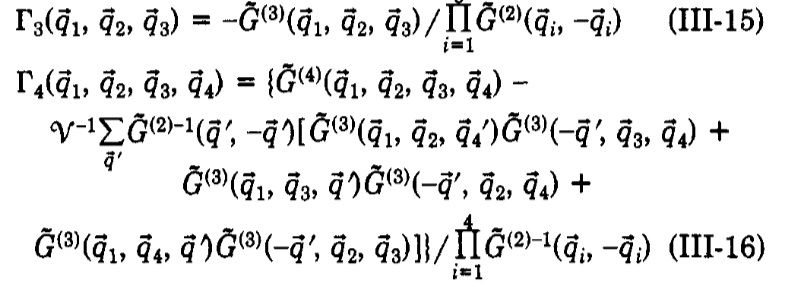

In [62]:
def gamma4(chrom, s_bnd_A, s_bnd_B, Ks):
    K1, K2, K3, K4 = Ks
    if np.linalg.norm(K1+K2+K3+K4) >= 1e-10:
        raise Exception('Qs must add up to zero')    
    K = np.linalg.norm(K1)
    K12 = np.linalg.norm(K1+K2)
    K13 = np.linalg.norm(K1+K3)
    K14 = np.linalg.norm(K1+K4)

    [n_bind, v_int, Vol_int, e_m, rho_c, rho_s, poly_marks, M, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom
    avo = 6.02e23 # num / mol
    dens_p = 1 # g/cm^3
    mol_weight_p = 1e5 # g/mol
    rho_p = avo*(1/mol_weight_p)*dens_p*M*(100**3)*(1/1e9)**3
    n_p = 1e8 

    M4 = calc_mon_mat_4(s_bnd_A, s_bnd_B)
    
    s4 = ( rho_p/(M*n_p) ) * calc_sf4(chrom, M4, [K1], [K2], [K3]) 
    s4[0,0,0,0] += rho_s

    M3 = calc_mon_mat_3(s_bnd_A, s_bnd_B)

    s3_12 = ( rho_p/(M*n_p) ) * calc_sf3(chrom, M3, [K1], [K2])
    s3_13 = ( rho_p/(M*n_p) ) * calc_sf3(chrom, M3, [K1], [K3])
    s3_14 = ( rho_p/(M*n_p) ) * calc_sf3(chrom, M3, [K1], [K4])
    s3_23 = ( rho_p/(M*n_p) ) * calc_sf3(chrom, M3, [K2], [K3])
    s3_24 = ( rho_p/(M*n_p) ) * calc_sf3(chrom, M3, [K2], [K4])
    s3_34 = ( rho_p/(M*n_p) ) * calc_sf3(chrom, M3, [K3], [K4])

    #s3 prefactor:  goal is 1/V * (N**3 * 1/N**3) = rho_p / (M * np)
    s3_12[0,0,0] += rho_s #solvent sf
    s3_13[0,0,0] += rho_s #solvent sf
    s3_14[0,0,0] += rho_s #solvent sf
    s3_23[0,0,0] += rho_s #solvent sf
    s3_24[0,0,0] += rho_s #solvent sf
    s3_34[0,0,0] += rho_s #solvent sf
    

    # calc m2s
    cc_red = eval_and_reduce_cc(M)
    s_cgam0_red = eval_and_reduce_cgam(s_bnd_A)
    s_cgam1_red = eval_and_reduce_cgam(s_bnd_B)
    sisj_AA_red = eval_and_reduce_sisj_bind_simp(chrom, s_bnd_A, s_bnd_A)
    sisj_AB_red = eval_and_reduce_sisj_bind_simp(chrom, s_bnd_A, s_bnd_B)
    sisj_BA_red = sisj_AB_red
    sisj_BB_red = eval_and_reduce_sisj_bind_simp(chrom, s_bnd_B, s_bnd_B)    
    M2s = [sisj_AA_red,sisj_AB_red,sisj_BA_red,sisj_BB_red, s_cgam0_red, s_cgam1_red, cc_red]
    
    S2_inv_red = sf2_inv(chrom, M2s, K, rho_p, n_p)
    S2_inv_red_12 = sf2_inv(chrom, M2s, K12, rho_p, n_p)
    S2_inv_red_13 = sf2_inv(chrom, M2s, K13, rho_p, n_p)
    S2_inv_red_14 = sf2_inv(chrom, M2s, K14, rho_p, n_p)

    S2_inv_red_2 = sf2_inv(chrom, M2s, K2, rho_p, n_p)
    S2_inv_red_3 = sf2_inv(chrom, M2s, K3, rho_p, n_p)
    S2_inv_red_4 = sf2_inv(chrom, M2s, K4, rho_p, n_p)

    part1 = np.einsum("ijkl, im, jn, ko, lp-> mnop", s4, S2_inv_red, S2_inv_red_2, S2_inv_red_3, S2_inv_red_4) \
    
    part2 = 0
    for q in Ks:
        s2_summed = sf2_inv(chrom, M2s, q, rho_p, n_p)
        part2 += np.einsum("ijk, ijk, il, jm, kn, il, jm -> ijk" ,s3_12, s3_34, s2_summed, S2_inv_red, S2_inv_red_2, S2_inv_red_3, S2_inv_red_4)
        part2 += np.einsum("ijk, ijk, il, jm, kn, il, jm -> ijk" ,s3_13, s3_24, s2_summed, S2_inv_red, S2_inv_red_2, S2_inv_red_3, S2_inv_red_4)
        part2 += np.einsum("ijk, ijk, il, jm, kn, il, jm -> ijk" ,s3_14, s3_23, s2_summed, S2_inv_red, S2_inv_red_2, S2_inv_red_3, S2_inv_red_4)
                               
    # np.einsum("", 
    return part1 - part2

# testing

In [12]:
mu_max = 2#0.1 #10
mu_min = -2#-9
del_mu = 5 #0.25

# mu_max = 10
# mu_min = -10
# del_mu = 10 #0.25

klog_min = -2.5
klog_max = -1
klog_num = 30


n_bind = 2 #types of proteins/marks


chi = None
#e_m = np.array([-1.52, -1.52]) #binding energy
e_m = np.array([1.52, 1.52]) #binding energy FOR F_BIND_ALT

#v_int =  np.array([[-3.92, 3], [3, -3.92]])
v_int =  np.array([[-4, 0], [0, -4]])
#v_int =  np.array([[0,4], [4,0]]) 


rho_c = (3e7)  /  ((4/3) * np.pi*  (5)**3 * (1000/1)**3) # nucleosomes per nm^3

avo = 6.02e23
water_molmas = 18
rho_s = avo * (1/water_molmas) * (1000  *(1000/1) * (1/1e9)**3)#  num / nm^3, pure water

#phi_c = 0.4# avg amount of chromosome

# chrom_type = "DNA"
#marks_1 = np.loadtxt(r"H3K9me3_ENCFF651ZTT_Chr_22_trimmed.txt").astype(np.uint8)
#marks_2 = np.loadtxt(r"H3K27me3_ENCFF470ECE_Chr_22_trimmed.txt").astype(np.uint8)

# marks_1 = np.loadtxt(r"HNCFF683HCZ_H3K9me3_methyl.txt").astype(np.uint8)
# marks_2 = np.loadtxt(r"ENCFF919DOR_H3K27me3_methyl.txt").astype(np.uint8)

#chrom_type = "test" #"DNA"  # test if 6 nucleosomes, DNA if using joes chromosome
#marks_1 = [0,2,1,0,2,1] # marks for protein 1
#marks_2 = [1,1,1,0,2,2] # marks for protein 2

chrom_type = "diblock"

nm = 50
pa_vec = np.arange(0, nm, 1) / (nm-1)
pb_vec = 1-pa_vec

poly_marks = [pa_vec, pb_vec]

chrom = def_chrom(n_bind, v_int, e_m, rho_c, rho_s, poly_marks, mu_max, mu_min, del_mu, chrom_type)

[n_bind, v_int, Vol_int, e_m, rho_c, rho_s, poly_marks, M, mu_max, mu_min, del_mu, f_om, N, N_m, b] = chrom

k_vec = np.logspace(klog_min, klog_max, klog_num) / (b)


s_bind_A, s_bind_B = calc_binding_states(chrom)

In [13]:
%%time
s_bnd_A = s_bind_A[0,0,:]
s_bnd_B = s_bind_B[0,0,:]

q_star = 0.01
lam_q = q_star*np.array([1, 0, 0])

K1, K2, K3, K4 =  np.array([lam_q, -lam_q, lam_q, -lam_q])

chi = 0
gamma2(chrom, s_bnd_A, s_bnd_B, q_star, chi)

CPU times: total: 0 ns
Wall time: 11 ms


array([[ 2849770.79016803, -2895769.98362963, -2895769.98362963],
       [-2895769.98362963,  2942141.18374784,  2942447.60472947],
       [-2895769.98362963,  2942447.60472947,  2942141.18374784]])

In [51]:
cyl_q1 = q_star*np.array([1, 0, 0])
cyl_q2 = 0.5*q_star*np.array([-1, np.sqrt(3), 0])
cyl_q3 = 0.5*q_star*np.array([-1, -np.sqrt(3), 0])
cyl_qs = np.array([cyl_q1, cyl_q2, cyl_q3])

gamma3(chrom, s_bnd_A, s_bnd_B, cyl_qs)

[0.01 0.   0.  ]


array([[[ 7.74022911e+20, -7.86516697e+20, -7.86516697e+20],
        [-7.86516697e+20,  7.99212151e+20,  7.99212151e+20],
        [-7.86516697e+20,  7.99212151e+20,  7.99212151e+20]],

       [[-7.86516697e+20,  7.99212151e+20,  7.99212151e+20],
        [ 7.99212151e+20, -8.12112526e+20, -8.12112526e+20],
        [ 7.99212151e+20, -8.12112526e+20, -8.12112526e+20]],

       [[-7.86516697e+20,  7.99212151e+20,  7.99212151e+20],
        [ 7.99212151e+20, -8.12112526e+20, -8.12112526e+20],
        [ 7.99212151e+20, -8.12112526e+20, -8.12112526e+20]]])

In [64]:
gamma4(chrom, s_bnd_A, s_bnd_B, np.array([lam_q, -lam_q, lam_q, -lam_q]))

[0.01 0.   0.  ]
[0.01 0.   0.  ]
[0.01 0.   0.  ]
[-0.01 -0.   -0.  ]
[-0.01 -0.   -0.  ]
[0.01 0.   0.  ]


C:\Users\tmhab\AppData\Local\Temp\ipykernel_205076\2889732245.py:29: RuntimeWarning: divide by zero encountered in scalar divide
  debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1)
C:\Users\tmhab\AppData\Local\Temp\ipykernel_205076\2889732245.py:29: RuntimeWarning: invalid value encountered in scalar multiply
  debye = (2/(x_m**2)) * (x_m + np.exp(-x_m) - 1)
C:\Users\tmhab\AppData\Local\Temp\ipykernel_205076\2889732245.py:37: RuntimeWarning: divide by zero encountered in scalar divide
  integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms
C:\Users\tmhab\AppData\Local\Temp\ipykernel_205076\2889732245.py:37: RuntimeWarning: invalid value encountered in scalar multiply
  integral = (1/(x_m**2)) * (np.exp(x_m) + np.exp(-x_m) - 2) #for off-diagonal terms


array([[[[ 6.02305510e+41, -1.46284685e+41, -1.46284685e+41],
         [ 1.48694277e+41, -3.92712028e+40, -3.43476540e+40],
         [ 1.48694277e+41, -3.43476540e+40, -3.92712028e+40]],

        [[ 1.48694277e+41, -3.92712028e+40, -3.43476540e+40],
         [ 4.44770842e+40, -1.23449745e+40, -1.00085350e+40],
         [ 3.08150911e+40, -7.57958914e+39, -7.57958914e+39]],

        [[ 1.48694277e+41, -3.43476540e+40, -3.92712028e+40],
         [ 3.08150911e+40, -7.57958914e+39, -7.57958914e+39],
         [ 4.44770842e+40, -1.00085350e+40, -1.23449745e+40]]],


       [[[ 6.02305510e+41, -1.46284685e+41, -1.46284685e+41],
         [ 1.48694277e+41, -3.92712028e+40, -3.43476540e+40],
         [ 1.48694277e+41, -3.43476540e+40, -3.92712028e+40]],

        [[ 1.48694277e+41, -3.92712028e+40, -3.43476540e+40],
         [ 4.44770842e+40, -1.23449745e+40, -1.00085350e+40],
         [ 3.08150911e+40, -7.57958914e+39, -7.57958914e+39]],

        [[ 1.48694277e+41, -3.43476540e+40, -3.92712028e+4

In [16]:
K1, K2, K3 = cyl_qs
M3 = calc_mon_mat_3(s_bnd_A, s_bnd_B)

calc_sf3(chrom, M3, [K1], [K2])

[0.01 0.   0.  ]


array([[[8.38446216e+13, 4.12565783e+13, 4.12565783e+13],
        [4.12565783e+13, 2.16352358e+13, 1.89662345e+13],
        [4.12565783e+13, 1.89662345e+13, 2.16352358e+13]],

       [[4.12565783e+13, 2.16352358e+13, 1.89662345e+13],
        [2.16352358e+13, 1.19592096e+13, 9.33253550e+12],
        [1.89662345e+13, 9.33253550e+12, 9.33253550e+12]],

       [[4.12565783e+13, 1.89662345e+13, 2.16352358e+13],
        [1.89662345e+13, 9.33253550e+12, 9.33253550e+12],
        [2.16352358e+13, 9.33253550e+12, 1.19592096e+13]]])